In [2]:
import qiskit
import qiskit_ibm_runtime
print(f"Qiskit version: {qiskit.__version__}")
print(f"Runtime version: {qiskit_ibm_runtime.__version__}")

Qiskit version: 2.1.0
Runtime version: 0.40.1


## 6교시 : Primitive inputs and outputs



아래 회로와 같이 양자 회로를 만들어봅시다.

![](img/ex11.png)

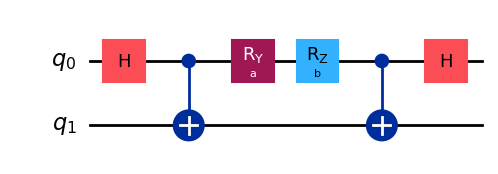

In [3]:
from qiskit.circuit import (
    Parameter,
    QuantumCircuit,
    ClassicalRegister,
    QuantumRegister,
)
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives.containers import BitArray

from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator
import numpy as np

# Define a circuit with two parameters.
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(Parameter("a"), 0)
circuit.rz(Parameter("b"), 0)
circuit.cx(0, 1)
circuit.h(0)
circuit.draw('mpl')

Parameter에 들어갈 값을 지정합니다.

In [4]:
# "a" 와 "b" 의 값을 각각 100개씩 설정해줍니다.
params = np.vstack(
    [
        np.linspace(-np.pi, np.pi, 100),
        np.linspace(-4 * np.pi, 4 * np.pi, 100),
    ]
).T
print(params)

[[ -3.14159265 -12.56637061]
 [ -3.07812614 -12.31250454]
 [ -3.01465962 -12.05863847]
 [ -2.9511931  -11.8047724 ]
 [ -2.88772658 -11.55090632]
 [ -2.82426006 -11.29704025]
 [ -2.76079354 -11.04317418]
 [ -2.69732703 -10.7893081 ]
 [ -2.63386051 -10.53544203]
 [ -2.57039399 -10.28157596]
 [ -2.50692747 -10.02770988]
 [ -2.44346095  -9.77384381]
 [ -2.37999443  -9.51997774]
 [ -2.31652792  -9.26611167]
 [ -2.2530614   -9.01224559]
 [ -2.18959488  -8.75837952]
 [ -2.12612836  -8.50451345]
 [ -2.06266184  -8.25064737]
 [ -1.99919533  -7.9967813 ]
 [ -1.93572881  -7.74291523]
 [ -1.87226229  -7.48904915]
 [ -1.80879577  -7.23518308]
 [ -1.74532925  -6.98131701]
 [ -1.68186273  -6.72745093]
 [ -1.61839622  -6.47358486]
 [ -1.5549297   -6.21971879]
 [ -1.49146318  -5.96585272]
 [ -1.42799666  -5.71198664]
 [ -1.36453014  -5.45812057]
 [ -1.30106362  -5.2042545 ]
 [ -1.23759711  -4.95038842]
 [ -1.17413059  -4.69652235]
 [ -1.11066407  -4.44265628]
 [ -1.04719755  -4.1887902 ]
 [ -0.98373103

In [5]:
# (3, 1) 행렬의 모양으로 3가지의 관측가능량을 정의해봅시다.
# XX, IY, 0.5 XX + 0.5 IY 입니다.
observables = [
    #
    [SparsePauliOp('XX')],
    [SparsePauliOp('IY')],
    # [0.5 * SparsePauliOp('XX') + 0.5 * SparsePauliOp('IY')]
    [SparsePauliOp.from_list([('XX', .5), ('IY', .5)])]
]

observables

[[SparsePauliOp(['XX'],
                coeffs=[1.+0.j])],
 [SparsePauliOp(['IY'],
                coeffs=[1.+0.j])],
 [SparsePauliOp(['XX', 'IY'],
                coeffs=[0.5+0.j, 0.5+0.j])]]

이제 회로를 트랜스파일 해봅시다.

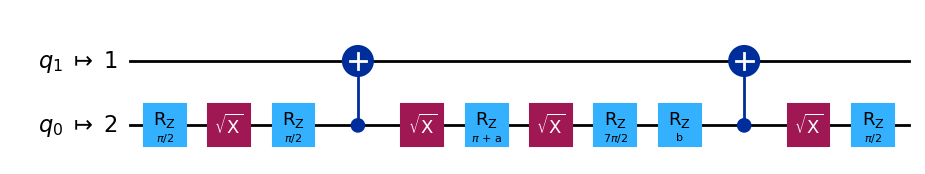

In [6]:
# 회로를 트랜스파일 해보세요.
#
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit.transpiler import generate_preset_pass_manager

backend = FakeVigoV2()
pm = generate_preset_pass_manager(backend=backend)
isa_circuit = pm.run(circuit)

isa_circuit.draw('mpl')

In [7]:
# 트랜스파일한 회로에 맞게 관측가능량도 매핑을 해줘야 합니다.
observables = [
    [observable.apply_layout(isa_circuit.layout) for observable in observable_set]
    for observable_set in observables
]

이제 아래와 같이 pub을 구성하여 Estimator를 실행해보겠습니다.

In [8]:
# 아래의 pub을 실행한 결괏값의 형태는 (3, 100)이 됩니다.
# 현재 파라미터의 형태가 (100, 2), 관측가능량의 형태가 (3, 1)이라는 것을 잘 기억해두세요.
estimator_pub = (isa_circuit, observables, params)

# estimator를 설정하여 실행합니다.
estimator = Estimator(mode=backend)
job = estimator.run([estimator_pub])
result = job.result()

실행한 결과를 같이 확인해볼까요?

In [9]:
#
result[0].data.evs


array([[ 0.0234375 ,  0.08056641,  0.11572266,  0.16894531,  0.23095703,
         0.27294922,  0.34667969,  0.37792969,  0.41894531,  0.46044922,
         0.53027344,  0.58740234,  0.62744141,  0.67871094,  0.69335938,
         0.74365234,  0.77246094,  0.80664062,  0.8203125 ,  0.84521484,
         0.86035156,  0.86865234,  0.88964844,  0.89697266,  0.90917969,
         0.90820312,  0.90527344,  0.89599609,  0.89501953,  0.8828125 ,
         0.85107422,  0.83691406,  0.81396484,  0.78271484,  0.74560547,
         0.71777344,  0.66162109,  0.66601562,  0.59716797,  0.54541016,
         0.51416016,  0.47607422,  0.41601562,  0.37353516,  0.30371094,
         0.28027344,  0.22412109,  0.13818359,  0.08007812,  0.01611328,
        -0.02197266, -0.09130859, -0.14550781, -0.18896484, -0.26953125,
        -0.30273438, -0.33837891, -0.42529297, -0.48339844, -0.51367188,
        -0.56494141, -0.58935547, -0.64746094, -0.69921875, -0.73779297,
        -0.75146484, -0.79931641, -0.80712891, -0.8

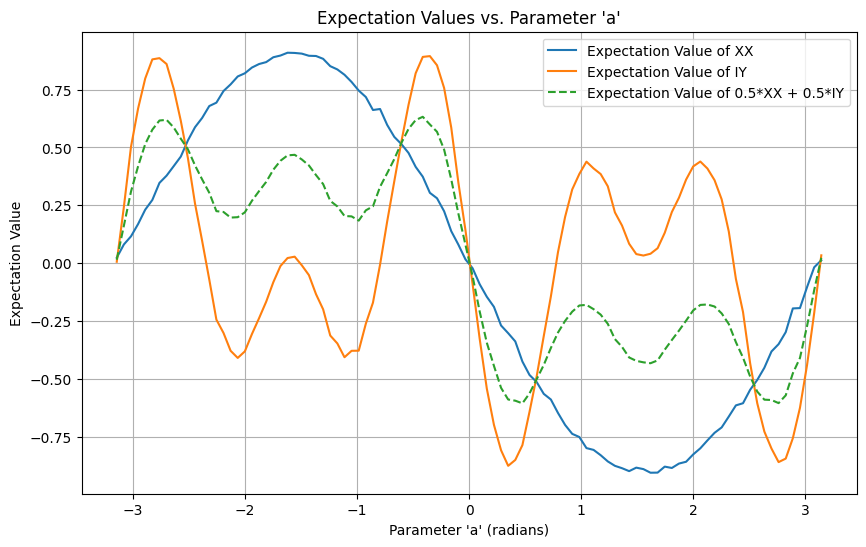

In [10]:
evs = result[0].data.evs

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

x_axis_data = params[:, 0]

y_axis_data_obs0 = evs[0] # XX의 기댓값
y_axis_data_obs1 = evs[1] # IY의 기댓값
y_axis_data_obs2 = evs[2] # 0.5 XX + 0.5 IY의 기댓값

plt.plot(x_axis_data, y_axis_data_obs0, label="Expectation Value of XX")
plt.plot(x_axis_data, y_axis_data_obs1, label="Expectation Value of IY")
plt.plot(x_axis_data, y_axis_data_obs2, label="Expectation Value of 0.5*XX + 0.5*IY", linestyle='--')

plt.title("Expectation Values vs. Parameter 'a'")
plt.xlabel("Parameter 'a' (radians)")
plt.ylabel("Expectation Value")
plt.legend()
plt.grid(True)
plt.show()

# import matplotlib.pyplot as plt

# for i in range(3):
#     plt.plot(result[0].data.evs[i])
# plt.show()

In [11]:
result[0].data.stds

array([[0.01562071, 0.01557421, 0.01552002, 0.0154004 , 0.01520256,
        0.01503169, 0.01465599, 0.01446616, 0.01418768, 0.01387009,
        0.01324729, 0.01264524, 0.01216662, 0.01147509, 0.01125925,
        0.01044635, 0.00992285, 0.00923503, 0.00893618, 0.00835042,
        0.00796408, 0.00774097, 0.0071351 , 0.00690759, 0.00650631,
        0.00653953, 0.00663796, 0.00693847, 0.00696917, 0.00733946,
        0.00820383, 0.0085521 , 0.00907678, 0.0097247 , 0.01041231,
        0.01087932, 0.01171622, 0.01165528, 0.01253307, 0.0130964 ,
        0.01340147, 0.0137407 , 0.01420871, 0.014494  , 0.01488694,
        0.01499875, 0.01522752, 0.0154751 , 0.01557482, 0.01562297,
        0.01562123, 0.01555973, 0.0154587 , 0.0153435 , 0.01504674,
        0.0148918 , 0.01470328, 0.0141415 , 0.01367813, 0.01340604,
        0.01289267, 0.01262303, 0.01190779, 0.01117043, 0.0105473 ,
        0.01030896, 0.00938922, 0.00922461, 0.00871324, 0.00805354,
        0.00753678, 0.0072382 , 0.00684533, 0.00

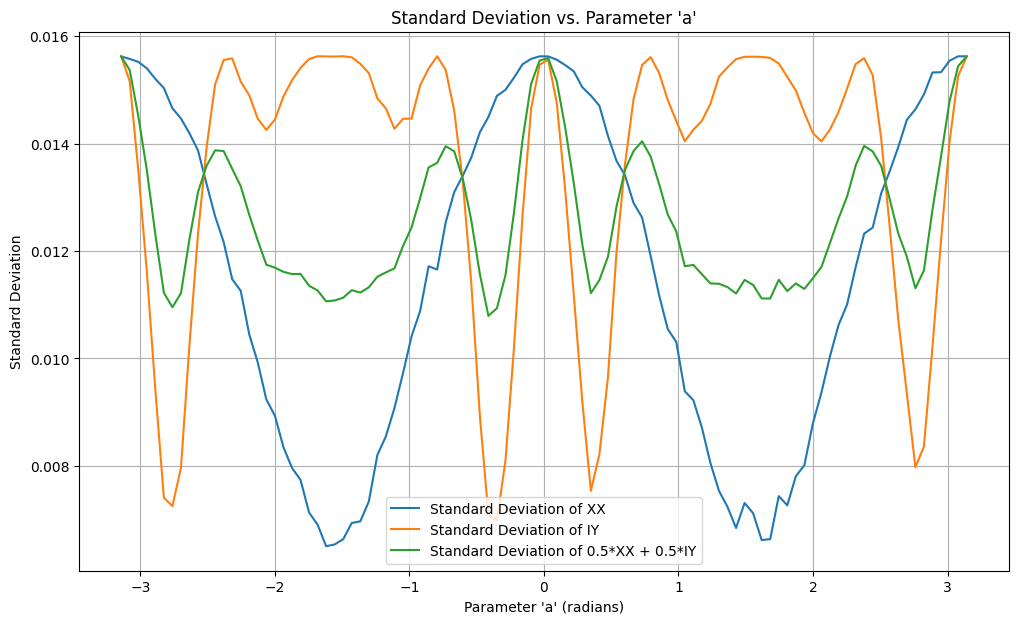

In [12]:
evs = result[0].data.evs
stds = result[0].data.stds

plt.figure(figsize=(12, 7))
x_axis_data = params[:, 0]

plt.plot(x_axis_data, stds[0], label=f"Standard Deviation of XX")
plt.plot(x_axis_data, stds[1], label=f"Standard Deviation of IY")
plt.plot(x_axis_data, stds[2], label=f"Standard Deviation of 0.5*XX + 0.5*IY")

plt.title("Standard Deviation vs. Parameter 'a'")
plt.xlabel("Parameter 'a' (radians)")
plt.ylabel("Standard Deviation")
plt.legend()
plt.grid(True)
plt.show()

### Broadcasting 규칙

PUB에 들어가는 변수들이 다양한 형태로 배열되어 있을 때 input을 구성하는 방식은 Numpy의 broadcasting 규칙을 따릅니다.자세한 설명은 [Qiskit 가이드](https://quantum.cloud.ibm.com/docs/en/guides/primitive-input-output)와 [NumPy broadcasting 규칙 문서](https://numpy.org/doc/stable/user/basics.broadcasting.html)를 참고하세요.

규칙:

*   입력값 배열은 서로 다른 차원과 크기를 가질 수 있습니다.
    *   결괏값의 배열은 입력값 배열의 각 차원에서 가장 큰 크기를 가져와 구성됩니다.
    *   누락된 차원이 있다면 해당 차원의 크기는 1로 가정합니다.
*   차원 크기는 가장 오른쪽(0차원)부터 순서대로 비교합니다.
*   두 배열의 각 차원의 크기는 서로 같거나 둘 중 하나가 1이어야 합니다.

broadcast 가능한 배열의 예시:

```text
A1     (1d array):      1
A2     (2d array):  3 x 5
Result (2d array):  3 x 5


A1     (3d array):  11 x 2 x 7
A2     (3d array):  11 x 1 x 7
Result (3d array):  11 x 2 x 7
```

broadcast가 되지 않는 배열의 예시:

```text
A1     (1d array):  5
A2     (1d array):  3

A1     (2d array):      2 x 1
A2     (3d array):  6 x 5 x 4 # 가운데 차원의 크기가 2였으면 broadcast가 가능했겠네요.
```

Qiskit primitive는 broadcast된 배열의 각 input을 가져와 결괏값을 계산합니다.

Broadcasting을 적용하는 주요 케이스에 대해 얘기해봅시다:

![This image illustrates several visual representations of array broadcasting](img/broadcasting.svg "Visual representation of broadcasting")



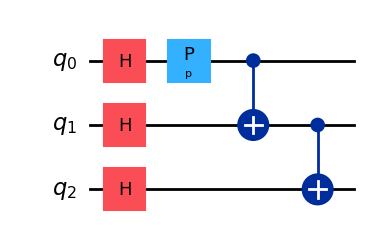

In [13]:
# 시나리오 1과 2에서 사용할, 파라미터가 1개인 공통 회로
p = Parameter('p')
qc_1_param = QuantumCircuit(3)
qc_1_param.h([0, 1, 2])
qc_1_param.p(p, 0) # 파라미터 'p' 하나만 사용
qc_1_param.cx(0, 1)
qc_1_param.cx(1, 2)
qc_1_param.draw('mpl')

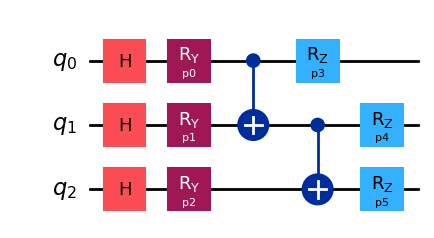

In [15]:
# 시나리오 3과 4에서 사용할, 파라미터가 6개인 공통 회로
params_6 = [Parameter(f'p{i}') for i in range(6)]
qc_6_params = QuantumCircuit(3)
qc_6_params.h([0, 1, 2])
qc_6_params.ry(params_6[0], 0); qc_6_params.ry(params_6[1], 1); qc_6_params.ry(params_6[2], 2)
qc_6_params.cx(0, 1); qc_6_params.cx(1, 2)
qc_6_params.rz(params_6[3], 0); qc_6_params.rz(params_6[4], 1); qc_6_params.rz(params_6[5], 2)
qc_6_params.draw('mpl')

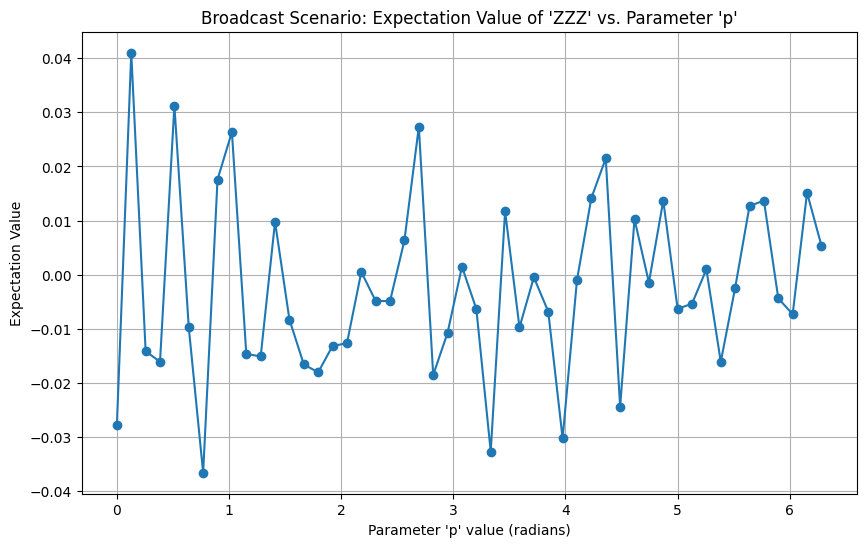

In [23]:
from qiskit_aer import AerSimulator

# Broadcast single observable
parameter_values = np.random.uniform(size=(5,))  # shape (5,)
observables = SparsePauliOp("ZZZ")  # shape ()
# >> pub result has shape (5,)

#    - 기본 시뮬레이터를 사용하는 Estimator를 준비합니다.
backend = AerSimulator()
estimator = Estimator(mode=backend)

#    - np.random.uniform 대신 np.linspace를 사용하면 더 깔끔한 그래프를 얻을 수 있습니다.
#    - 0부터 2*pi까지 50개의 파라미터 값을 준비합니다.
parameter_values = np.linspace(0, 2 * np.pi, 50) # shape (50,)
parameter_values = parameter_values.reshape(-1, 1) # to shape (50, 1)
observables = SparsePauliOp("ZZZ")              # shape ()


# Estimator를 실행하여 기댓값을 계산합니다.
job = estimator.run(pubs=[(qc_1_param, observables, parameter_values)])
result = job.result()
evs = result[0].data.evs # evs = Expectation Values

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(parameter_values, evs, marker='o', linestyle='-')
plt.title("Broadcast Scenario: Expectation Value of 'ZZZ' vs. Parameter 'p'")
plt.xlabel("Parameter 'p' value (radians)")
plt.ylabel("Expectation Value")
plt.grid(True)
plt.show()

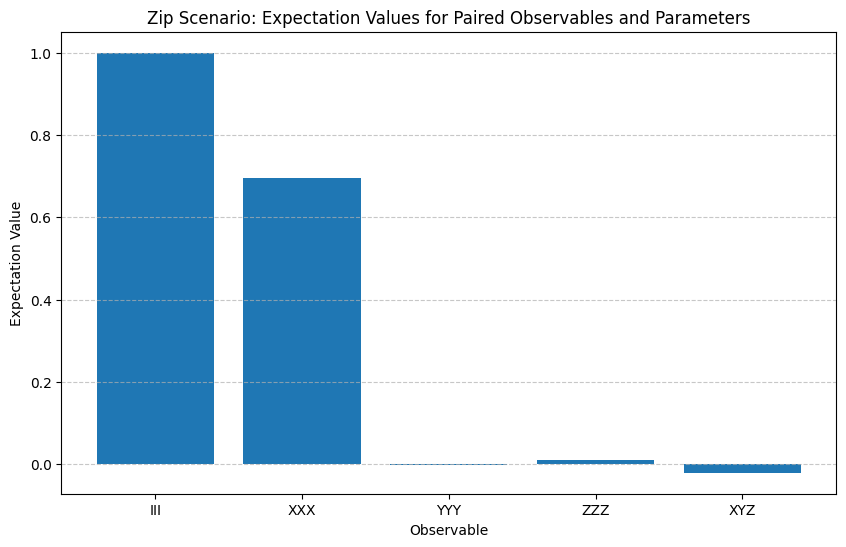

In [25]:
# Zip
parameter_values = np.random.uniform(size=(5,))  # shape (5,)
observables = [
    SparsePauliOp(pauli) for pauli in ["III", "XXX", "YYY", "ZZZ", "XYZ"]
]  # shape (5,)
# >> pub result has shape (5,)

# 3. 파라미터 값들과 관측가능량 리스트를 정의합니다.
parameter_values = np.linspace(0, np.pi, 5) # shape (5,)
parameter_values = parameter_values.reshape(-1, 1)
observables = [
    SparsePauliOp(pauli) for pauli in ["III", "XXX", "YYY", "ZZZ", "XYZ"]
]  # shape (5,)

# 5. Estimator를 실행하여 기댓값을 계산합니다.
#    (parameter_values[0]과 observables[0]을 짝지어 계산)
#    (parameter_values[1]과 observables[1]을 짝지어 계산)
job = estimator.run(pubs=[(qc_1_param, observables, parameter_values)])
result = job.result()
evs = result[0].data.evs

# 6. 결과를 막대그래프로 시각화합니다.
observable_labels = [obs.paulis.to_labels()[0] for obs in observables]

plt.figure(figsize=(10, 6))
plt.bar(observable_labels, evs)
plt.title("Zip Scenario: Expectation Values for Paired Observables and Parameters")
plt.xlabel("Observable")
plt.ylabel("Expectation Value")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

입력 shape >> params: (1, 6), obs: (4, 1, 8, 8)
결과 shape >> evs: (4, 1)


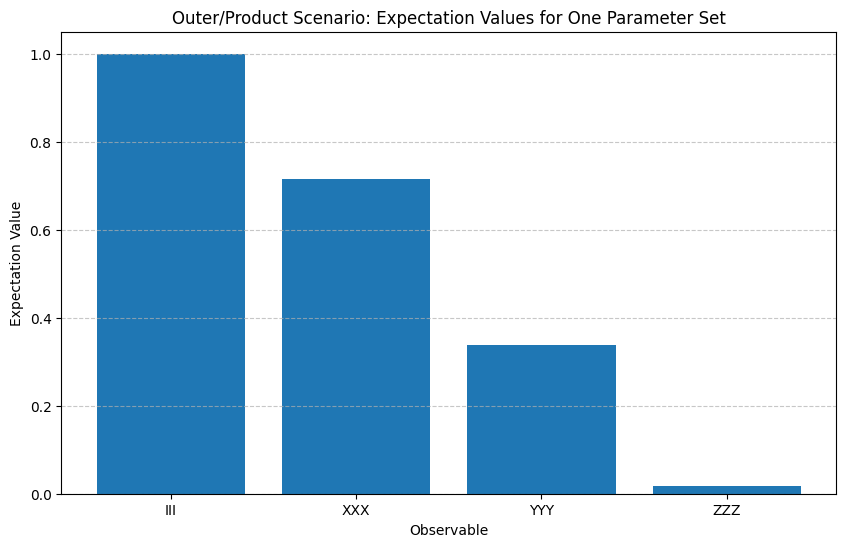

In [ ]:
# Outer/Product
parameter_values = np.random.uniform(size=(1, 6))  # shape (1, 6)
observables = [
    [SparsePauliOp(pauli)] for pauli in ["III", "XXX", "YYY", "ZZZ"]
]  # shape (4, 1)
# >> pub result has shape (4, 6)

# Estimator 실행
job = estimator.run(pubs=[(qc_6_params, observables, parameter_values)])
result = job.result()
evs = result[0].data.evs

print(f"입력 shape >> params: {parameter_values.shape}, obs: {np.array(observables).shape}")
print(f"결과 shape >> evs: {evs.shape}")


# 시각화
observable_labels = [obs[0].paulis.to_labels()[0] for obs in observables]

plt.figure(figsize=(10, 6))
plt.bar(observable_labels, evs.flatten()) 
plt.title("Outer/Product Scenario: Expectation Values for One Parameter Set")
plt.xlabel("Observable")
plt.ylabel("Expectation Value")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Estimator를 실행하여 기댓값을 계산합니다...
입력 shape >> params: (3, 6), obs: (2, 3, 1, 8, 8)
결과 shape >> evs: (2, 3, 3)


RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

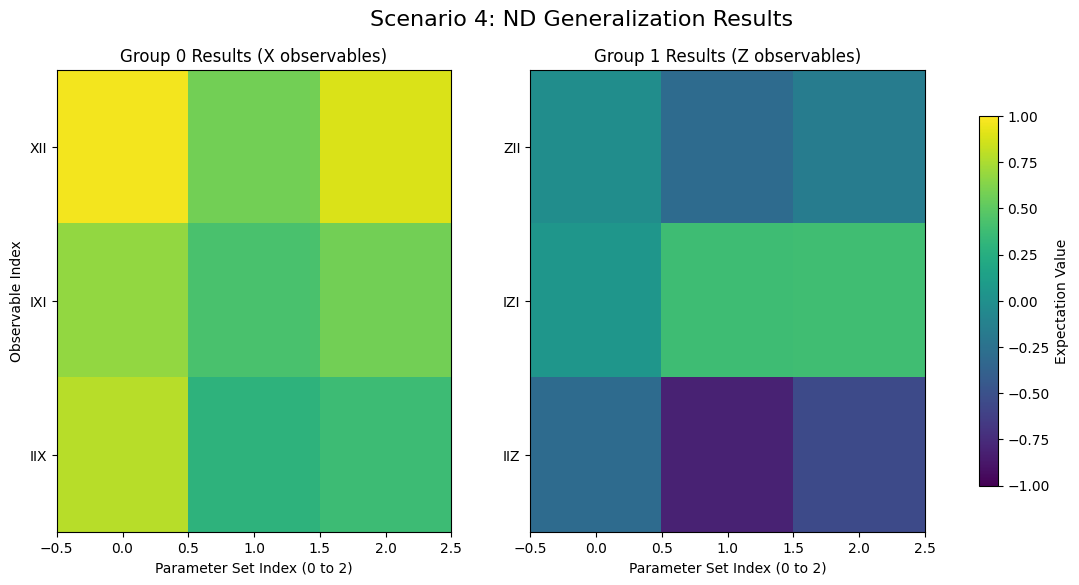

In [33]:
# Standard nd generalization
parameter_values = np.random.uniform(size=(3, 6))  # shape (3, 6)
observables = [
    [
        [SparsePauliOp(["XII"])],
        [SparsePauliOp(["IXI"])],
        [SparsePauliOp(["IIX"])],
    ],
    [
        [SparsePauliOp(["ZII"])],
        [SparsePauliOp(["IZI"])],
        [SparsePauliOp(["IIZ"])],
    ],
]
# >> pub result has shape (2, 3, 1)

# Estimator 실행
print("Estimator를 실행하여 기댓값을 계산합니다...")
job = estimator.run(pubs=[(qc_6_params, observables, parameter_values)])
result = job.result()
evs = result[0].data.evs

print(f"입력 shape >> params: {parameter_values.shape}, obs: {np.array(observables).shape}")
print(f"결과 shape >> evs: {evs.shape}")


# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
fig.suptitle("Scenario 4: ND Generalization Results", fontsize=16)

# 첫 번째 히트맵: X 관련 관측가능량 그룹
im1 = axes[0].imshow(evs[0], cmap='viridis', aspect='auto', vmin=-1, vmax=1)
axes[0].set_title("Group 0 Results (X observables)")
axes[0].set_xlabel("Parameter Set Index (0 to 2)")
axes[0].set_ylabel("Observable Index")
axes[0].set_yticks(range(3), ["XII", "IXI", "IIX"])

# 두 번째 히트맵: Z 관련 관측가능량 그룹
im2 = axes[1].imshow(evs[1], cmap='viridis', aspect='auto', vmin=-1, vmax=1)
axes[1].set_title("Group 1 Results (Z observables)")
axes[1].set_xlabel("Parameter Set Index (0 to 2)")
axes[1].set_yticks(range(3), ["ZII", "IZI", "IIZ"])

fig.colorbar(im2, ax=axes.tolist(), label="Expectation Value", shrink=0.8)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


위에서 주어진 케이스를 실행해보고 앞에서와 같이 그래프로 나타내봅시다.

In [ ]:
#